In [19]:
# MajorityVoteClassifierクラス
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key , value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
    
    def fit(self ,X,y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote - np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            maj_vote = np.apply_along_axis(lambda x:np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
            
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
    
    def predict_proba(self, X):
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name , step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name,key)] = value
            return out
    


In [20]:
#データ取得
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]],iris.target[50:]
le=LabelEncoder()
y= le.fit_transform(y)

X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=1) 

#分類器
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001,random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ['Logisitic Regression', 'Decision Tree', 'KNN']
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

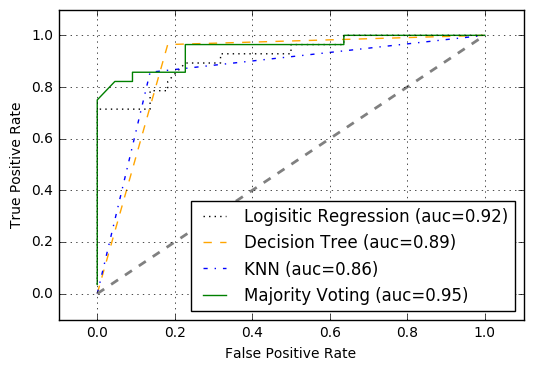

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

colors = ['black', 'orange', 'blue','green']
linestyles=[':', '--', '-.','-']
for clf , label, clr, ls in zip(all_clf, clf_labels,colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,color=clr,linestyle=ls, label='%s (auc=%0.2f)' % (label, roc_auc))
    
plt.legend(loc='lower right')
plt.plot([0,1],[0,1], linestyle='--', color='gray',linewidth=2)
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

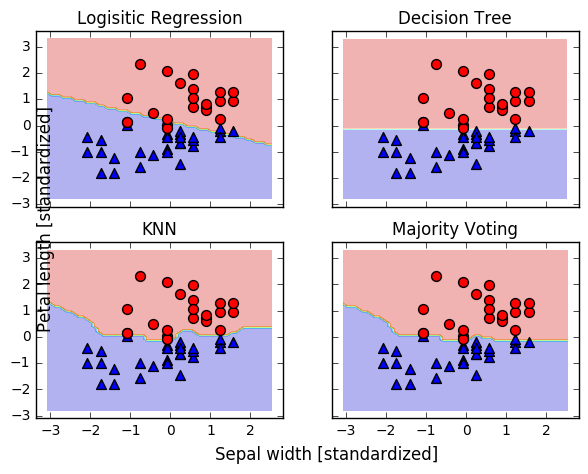

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             presort=False, random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_split': 1e-07,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[['sc', StandardScaler(copy=True, with_mean=True, with_

In [22]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product

x_min = X_train_std[:,0].min()-1
x_max = X_train_std[:,0].max()+1
y_min = X_train_std[:,1].min()-1
y_max = X_train_std[:,1].max()+1

xx,yy = np.meshgrid(np.arange(x_min,x_max, 0.1), np.arange(y_min, y_max, 0.1))
f, axarr =plt.subplots(nrows=2, ncols=2,sharex='col',sharey='row', figsize=(7,5))

for idx, clf, tt in zip(product([0,1],[0,1]), all_clf,clf_labels):
    clf.fit(X_train_std,y_train)
    Z= clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0,0],X_train_std[y_train==0,1], c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1,0],X_train_std[y_train==1,1], c='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)
    
plt.text(-3.5, -4.5, s='Sepal width [standardized]',ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length [standardized]',ha='center', va='center', fontsize=12,rotation=90)
plt.show()
mv_clf.get_params()

In [27]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth':[1,2],'pipeline-1__clf__C':[0.001,0.1,100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)

for params, mean_score, scores in grid.grid_scores_:
    print('%0.3f+/-%0.2f %r' % (mean_score,scores.std()/2,params))
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.000+/-0.00 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}
Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
Accuracy: 1.00


/Users/ishii0514/dev/pythonenv/mlearn/lib/python3.5/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
